# Homework 9: Correlation, Regression, and Least Squares

Please complete this notebook by filling in the cells provided. When you’re done, follow the instructions in [this short explainer video](https://www.youtube.com/watch?v=gMt_Rq43y_4&ab_channel=FahadKamran) to submit your homework.

If you cannot submit online, come to office hours for assistance. The office hours
schedule appears on [data8.org/fa16/weekly.html](http://data8.org/fa16/weekly.html).

This assignment is due Thursday, November 10 at 7PM. You will receive an early submission bonus point if you turn it in by Wednesday, November 3 at 7PM. Directly sharing answers is not okay, but discussing problems with course staff or with other students is encouraged.

**Important note:** Only Parts 1 and 2 of this assignment will be graded.  Parts 3 and 4 of this assignment will not be graded and are intended to give you extra practice.

Reading:
- Textbook chapter [12](https://www.inferentialthinking.com/chapters/12/why-the-mean-matters.html) (for review)
- Textbook chapter [13](https://www.inferentialthinking.com/chapters/13/prediction.html)

Run the cell below to prepare the notebook.

In [1]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
from matplotlib import patches
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from client.api.assignment import load_assignment
tests = load_assignment('hw09.ok')

/Users/chenshangheng/opt/anaconda3/lib/python3.8/site-packages/datascience/tables.py:17: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/Users/chenshangheng/opt/anaconda3/lib/python3.8/site-packages/datascience/util.py:10: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


Assignment: Homework 9: Correlation, Regression, and Least Squares
OK, version v1.18.1



## Evaluating NBA Game Predictions

#### A brief introduction to sports betting
In a basketball game, each team scores some number of points.  Conventionally, the team playing at its own arena is called the "home team," and the other team is called the "away team."  The winner, of course, is the team with the most points.  So we could summarize what happened in a game by the following number:

$$\text{outcome} = \text{points scored by the away team} - \text{points scored by the home team}$$

If this number is positive, the away team won.  If it's negative, the home team won.  For brevity, we'll use the shorthand **"outcome"** for **the away team's score minus the home team's score**.

Casinos in Las Vegas offer bets on the outcomes of NBA games.  One kind of bet works like this:

1. The casino decides on a "spread."
2. You can bet \$11 that the outcome will be above the spread, or \$11 that the outcome will be below the spread.
3. After the game, you end up with \$21 if you guessed correctly, and \$0 if you guessed incorrectly.

The analysts at the casino try to choose the spread so that (according to their analysis of the teams) there is a 50% chance that the outcome will be below that amount, and a 50% chance that the outcome will be above that amount.

**[tl;dr](https://en.wikipedia.org/wiki/Wikipedia:Too_long;_didn%27t_read): The spread is the casino's best guess at the outcome (the away team's score minus the home team's score).**

The table `spreads` contains spreads from the betting website [Covers](http://www.covers.com) from every game in the 2014 NBA season, plus actual game outcomes.  

In [2]:
spreads = Table.read_table("spreads.csv")
spreads

Date,Home Team,Away Team,Home Points,Away Points,Outcome,Spread
4/10/2015,Utah,Memphis,88,89,1,2.5
3/10/2015,Utah,New York,87,82,-5,-13
11/19/2014,Indiana,Charlotte,88,86,-2,-2
11/15/2014,Chicago,Indiana,90,99,9,-9
3/25/2015,Utah,Portland,89,92,3,-2
3/3/2015,Memphis,Utah,82,93,11,-7
3/18/2015,Utah,Washington,84,88,4,-3
3/16/2015,Utah,Charlotte,94,66,-28,-4.5
1/24/2015,Charlotte,New York,76,71,-5,-9
11/7/2014,Oklahoma City,Memphis,89,91,2,7


#### Question 1
Make a scatter plot of the outcomes and spreads, with the spreads on the horizontal axis.

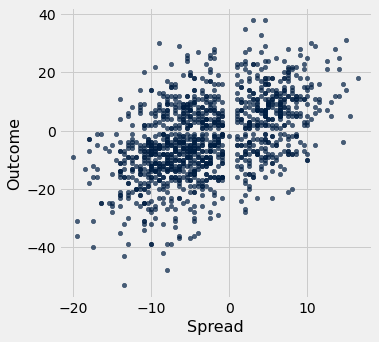

In [3]:
spreads.scatter(6, 5)

<div class="hide">\pagebreak</div>
You might notice that spreads and outcomes are (almost) never 0.  It's because a game of basketball never ends in a tie; one team has to win.

Let's investigate how well the casinos are predicting game outcomes.

One question we can ask is: Is the casino's prediction correct on average? In other words, for every value of the spread, is the average outcome of games assigned that spread equal to the spread? If not, the casino would apparently be making a systematic error in its predictions.

#### Question 2
Among games with a spread around 5 (concretely: in the range $[3.5, 6.5]$), what was the average outcome?

In [4]:
spreads_around_5 = spreads.where("Spread", are.between_or_equal_to(3.5, 6.5))
spread_5_outcome_average = np.mean(spreads_around_5.column("Outcome"))
print("Average outcome:", spread_5_outcome_average)

Average outcome: 4.9941176470588236


Instead of doing that for each possible spread, we can use linear regression to predict an outcome for any spread.

#### Question 3
If the average outcome for games with each spread is roughly equal to that spread, what would you expect the slope and intercept of the linear regression line to be?  Or is it impossible to say?  If it's impossible, use the cell below to write a comment explaining why.  Otherwise, write the expected slope and intercept.

In [5]:
spread_std = np.std(spreads.column("Spread"))
spread_mean = np.mean(spreads.column("Spread"))
outcome_std = np.std(spreads.column("Outcome"))
outcome_mean = np.mean(spreads.column("Outcome"))
spread_united = (spreads.column("Spread") - spread_mean) / spread_std
outcome_united = (spreads.column("Outcome") - outcome_mean) / outcome_std
r = np.mean(spread_united * outcome_united)

expected_slope = r * outcome_std / spread_std
expected_intercept = outcome_mean - expected_slope * spread_mean

Let's compute the regression line and find out if that's the case.  This takes a few steps.

#### Question 4
Define a function called `standard_units`.  It should take an array of numbers as its argument and return an array of those numbers in standard units.

In [7]:
def standard_units(nums):
    """Converts an array of numbers to standard units."""
    num_mean = np.mean(nums)
    num_std = np.std(nums)
    return (nums - num_mean) / num_std

#### Question 5
Compute the correlation between outcomes and spreads.

In [8]:
spread_r = np.mean(standard_units(spreads.column(6)) * standard_units(spreads.column(5)))
spread_r

0.49181413688314235

#### Question 6
Compute the slope and intercept of the least-squares linear regression line that predicts outcomes from spreads.

In [9]:
spread_slope = r * np.std(spreads.column(5)) / np.std(spreads.column(6))
spread_intercept = np.mean(spreads.column(5)) - spread_slope * np.mean(spreads.column(6))
print("predicted outcome = {:f}*spread + {:f}".format(spread_slope, spread_intercept))

predicted outcome = 0.953927*spread + 0.220248


#### Question 7
For each game in `spreads`, compute the predicted outcome using your regression line.  Add these to `spreads` as a column called `"Predicted outcome"`, naming the resulting table `with_predictions`.

In [10]:
with_predictions = spreads.with_column("Predicted outcome", spread_slope * spreads.column(6) + spread_intercept)
with_predictions

Date,Home Team,Away Team,Home Points,Away Points,Outcome,Spread,Predicted outcome
4/10/2015,Utah,Memphis,88,89,1,2.5,2.60507
3/10/2015,Utah,New York,87,82,-5,-13,-12.1808
11/19/2014,Indiana,Charlotte,88,86,-2,-2,-1.68761
11/15/2014,Chicago,Indiana,90,99,9,-9,-8.3651
3/25/2015,Utah,Portland,89,92,3,-2,-1.68761
3/3/2015,Memphis,Utah,82,93,11,-7,-6.45724
3/18/2015,Utah,Washington,84,88,4,-3,-2.64153
3/16/2015,Utah,Charlotte,94,66,-28,-4.5,-4.07242
1/24/2015,Charlotte,New York,76,71,-5,-9,-8.3651
11/7/2014,Oklahoma City,Memphis,89,91,2,7,6.89774


Here's a plot of the predictions.

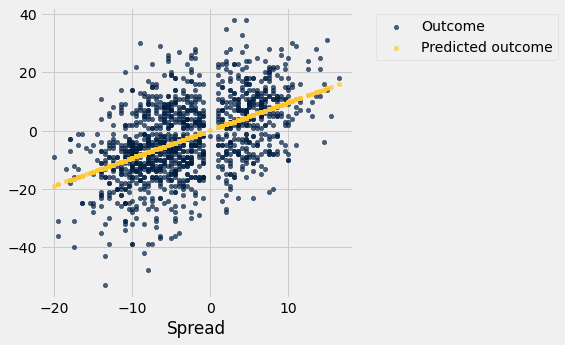

In [11]:
with_predictions.scatter("Spread", make_array("Outcome", "Predicted outcome"))

#### Question 8
Is it true that the average outcome for games with each spread is around that spread?

*Since r is not close to 1, the average outcome is also not around the expected.*

#### Question 9
Do you think the casino predicted game outcomes *accurately*?  What number would you use to quantify that?

*No, r!!!!.*

## Finding the Least Squares Regression Line

In this exercise, you'll work with a small, abstract dataset of 5 x/y pairs.  You'll see 3 ways to find the least-squares regression line.

Run the next cell to generate the dataset `d` and see a scatter plot.

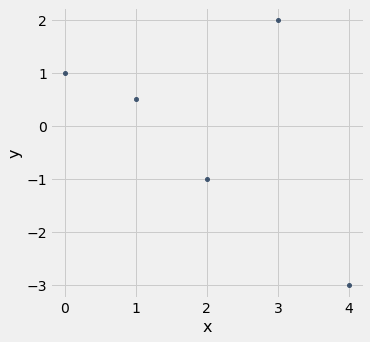

In [6]:
d = Table().with_columns(
    'x', make_array(0,  1,  2,  3,  4),
    'y', make_array(1, .5, -1,  2, -3))
d.scatter('x')

<div class="hide">\pagebreak</div>
When you run it, the next cell generates sliders that control the slope and intercept of a potential line.  When you adjust a slider, the line will move.

#### Question 1
By moving the line around, make your best guess at the least-squares regression line.  (It's okay if your line isn't exactly right, as long as it's reasonable.)

**Note:** Python will probably take about a second to redraw the plot each time you adjust the slider.  We suggest clicking the place on the slider you want to try and waiting for the plot to be drawn; dragging the slider handle around will cause a long lag.

In [7]:
def plot_line(slope, intercept):
    plt.figure(figsize=(5,5))
    
    endpoints = make_array(-2, 7)
    p = plt.plot(endpoints, slope*endpoints + intercept, color='orange', label='Proposed line')
    
    plt.scatter(d.column('x'), d.column('y'), color='blue', label='Points')
    
    plt.xlim(-4, 8)
    plt.ylim(-6, 6)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.legend(bbox_to_anchor=(1.8, .8))

interact(plot_line, slope=widgets.FloatSlider(min=-4, max=4, step=.1), intercept=widgets.FloatSlider(min=-4, max=4, step=.1));

interactive(children=(FloatSlider(value=0.0, description='slope', max=4.0, min=-4.0), FloatSlider(value=0.0, d…

<div class="hide">\pagebreak</div>

You can probably find a reasonable-looking line by just eyeballing it.  But remember: the least-squares regression line minimizes the mean of the squared errors made by the line for each point.  Your eye might not be able to judge squared errors very well.

#### A note on mean and total squared error
Before we move on, a note is in order.

It is common to think of the least-squares line as the line with the least *mean* squared error (or the square root of the mean squared error), as the textbook does.

But it turns out that it doesn't matter whether you minimize the mean squared error or the *total* squared error.  You'll get the same best line in either case.

That's because the total squared error is just the mean squared error multipled by the number of points (`d.num_rows`).  So if one line gets a better total squared error than another line, then it also gets a better mean squared error.  In particular, the line with the smallest total squared error is also better than every other line in terms of mean squared error.  That makes it the least squares line.

#### Question 2
The next cell produces a more useful plot.  Use it to find a line that's closer to the least-squares regression line, keeping the above note in mind.

In [8]:
def plot_line_and_errors(slope, intercept):
    plt.figure(figsize=(5,5))
    points = make_array(-2, 7)
    p = plt.plot(points, slope*points + intercept, color='orange', label='Proposed line')
    ax = p[0].axes
    
    predicted_ys = slope*d.column('x') + intercept
    diffs = predicted_ys - d.column('y')
    for i in np.arange(d.num_rows):
        x = d.column('x').item(i)
        y = d.column('y').item(i)
        diff = diffs.item(i)
        
        if diff > 0:
            bottom_left_x = x
            bottom_left_y = y
        else:
            bottom_left_x = x + diff
            bottom_left_y = y + diff
        
        ax.add_patch(patches.Rectangle(make_array(bottom_left_x, bottom_left_y), abs(diff), abs(diff), color='red', alpha=.3, label=('Squared error' if i == 0 else None)))
        plt.plot(make_array(x, x), make_array(y, y + diff), color='red', alpha=.6, label=('Error' if i == 0 else None))
    
    plt.scatter(d.column('x'), d.column('y'), color='blue', label='Points')
    
    plt.xlim(-4, 8)
    plt.ylim(-6, 6)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.legend(bbox_to_anchor=(1.8, .8))

interact(plot_line_and_errors, slope=widgets.FloatSlider(min=-4, max=4, step=.1), intercept=widgets.FloatSlider(min=-4, max=4, step=.1));

interactive(children=(FloatSlider(value=0.0, description='slope', max=4.0, min=-4.0), FloatSlider(value=0.0, d…

#### Question 3
Describe the visual criterion you used to find a line in question 2.  (For example, a possible (but incorrect) answer is, "I tried to make the red line for the bottom-right point as small as possible.")

*I tried to make the pink square for the bottom-right point as small as possible..*

#### Question 4
Does the point at (3, 2) have more or less influence than any other point on the location of the line?

*Yes. Only this point is out of the line.*

Now, let's have Python find this line for us.  When we use `minimize`, Python goes through a process similar to the one you might have used in question 2.

But Python can't look at a plot that displays errors!  Instead, we tell it how to find the total squared error for a line with a given slope and intercept.

#### Question 5
Define a function called `total_squared_error`.  It should take two numbers as arguments:

1. the slope of some potential line
2. the intercept of some potential line

It should return the total squared error when we use that line to make predictions for the dataset `d`.

In [9]:
def total_squared_error(slope, intercept):
    # Hint: The staff answer computed an array called predictions
    # and an array called errors first.
    x = make_array(0,  1,  2,  3,  4)
    y = make_array(1, .5, -1,  2, -3)
    predictions = slope * x + intercept
    errors = (y - predictions) ** 2
    return errors.sum()

In [10]:
_ = tests.grade('q2_5')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 6
What is the total squared error for the line you found by "eyeballing" the errors in the first question?  What about the question after that, where you had a better visual aid?  (It's okay if the error went up!)

In [11]:
eyeballed_error = total_squared_error(-1.1, 3.5)
aided_error = total_squared_error(-1, 2.3)
print("Eyeballed error:", eyeballed_error, "\nAided error:", aided_error)

Eyeballed error: 22.799999999999997 
Aided error: 12.999999999999998


#### Question 7
Use `minimize` to find the actual slope and intercept of the least-squares regression line.

**Note:** `minimize` will return a single array containing the slope as the first element and intercept as the second.

In [12]:
# The staff solution used 1 line of code above here.
slope_from_minimize, intercept_from_minimize = minimize(total_squared_error)

print("Least-squares regression line: predicted_y = {:f}*x + {:f}".format(slope_from_minimize, intercept_from_minimize))

Least-squares regression line: predicted_y = -0.649837*x + 1.198862


#### Question 8
What was the total squared error for that line?

In [15]:
best_total_squared_error = total_squared_error(-0.649837, 1.198862)
best_total_squared_error

10.97500356241

Run the following cell to plot this line and its errors:

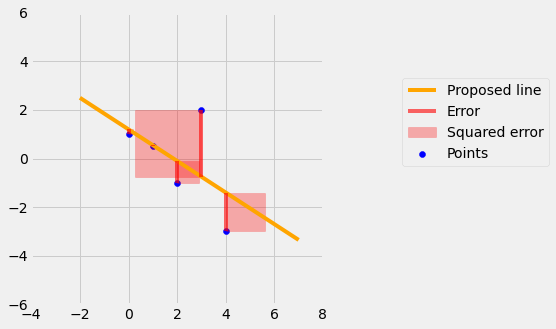

In [14]:
plot_line_and_errors(slope_from_minimize, intercept_from_minimize)

#### Question 9
Compute the correlation between the `"x"` and `"y"` columns, then use the formula in [13.2](https://www.inferentialthinking.com/chapters/13/2/regression-line.html) to find the slope and intercept of the least-squares regression line.

In [24]:
x_mean = np.mean(d.column('x'))
x_std = np.std(d.column('x'))
y_mean = np.mean(d.column('y'))
y_std = np.std(d.column('y'))
# The staff solution used 4 lines of code before this.
d_r = np.mean(((d.column('x') - x_mean) / x_std) * ((d.column('y') - y_mean) / y_std))
slope_from_r = d_r * y_std / x_std
intercept_from_r = y_mean - slope_from_r * x_mean
print("Regression line computed from the correlation: predicted_y = {:f}*x + {:f}".format(slope_from_r, intercept_from_r))

Regression line computed from the correlation: predicted_y = -0.650000*x + 1.200000


Compare this with your answer to question 7 to verify that they're both correct.  They will be a little bit different, because `minimize` is by default accurate only to within $0.01$.  (If they're not roughly the same, try computing the total squared error for both; the one with the smaller error is more likely correct!)

## Triple Jump Distances vs. Vertical Jump Heights 

Does skill in one sport imply skill in a related sport?  The answer might be different for different activities.  Let us find out whether it's true for the [triple jump](https://en.wikipedia.org/wiki/Triple_jump) (an horizontal jump similar to a long jump) and the vertical jump.  Since we're learning about linear regression, we will look specifically for a *linear* association between skill in the two sports.

The following data was collected by observing 40 collegiate level soccer players.  Each athlete's distance in both jump activities was measured (in centimeters). Run the cell below to load the data.

In [25]:
# Run this cell to load the data
jumps = Table.read_table('triple_vertical.csv')
jumps

triple,vertical
383,33
781,71.1
561.62,62.25
624.52,61.33
446.24,40.19
515.3,38.96
449.22,39.69
560.91,46.51
519.12,37.68
595.38,53.48


#### Question 1
Before running a regression, it's important to see what the data look like, because our eyes are good at picking out unusual patterns in data.  Draw a scatter plot with the triple jump distances on the horizontal axis and the vertical jump heights on vertical axis.

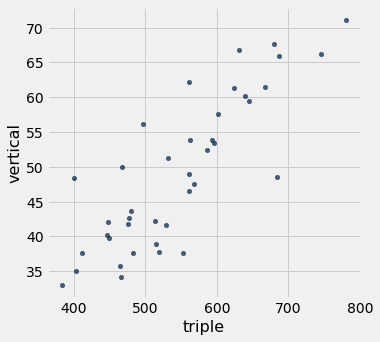

In [26]:
jumps.scatter('triple')

**Question 2** Does the correlation coefficient `r` look closer to 0, .5, or -.5? Explain. 

*0.5.*

#### Question 3
Create a function called `regression_parameters`. It takes as its argument a table with two columns.  The first column is the x-axis, and the second column is the y-axis.  It should compute the correlation between the two columns, then compute the slope and intercept of the regression line that predicts the second column from the first.  It should return an array with three elements: the correlation coefficient of the two columns, the slope of the regression line, and the intercept of the regression line.

**Hint:** You did a similar thing in lab, though it was spread out across several questions.

In [28]:
def regression_parameters(tbl):
    x_std = np.std(tbl.column(0))
    x_mean = np.mean(tbl.column(0))
    y_std = np.std(tbl.column(1))
    y_mean = np.mean(tbl.column(1))
    # Our solution had 4 lines above this one
    r = np.mean(((tbl.column(0) - x_mean) / x_std) * ((tbl.column(1) - y_mean) / y_std))
    slope = r * y_std / x_std
    intercept = y_mean - slope * x_mean
    return make_array(r,slope,intercept)

# When your function is finished, the next lines should
# perform a regression predicting vertical jump distances
# from triple jump distances.
parameters = regression_parameters(jumps)
jumps_r = parameters.item(0)
jumps_slope = parameters.item(1)
jumps_intercept = parameters.item(2)

#### Question 4
Let's use `regression_parameters` to predict what certain athletes' vertical jump heights would be given their triple jump distances.

The world record for the triple jump distance is 18.29 *meters* by Johnathan Edwards. What's our prediction for what Edwards' vertical jump would be?

In [30]:
triple_record_vert_est = jumps_slope * 1829 + jumps_intercept
print("Predicted vertical jump distance: {:f} centimeters".format(triple_record_vert_est))

Predicted vertical jump distance: 168.452347 centimeters


#### Question 5
Do you trust this estimate? Why or why not?

*I don't know what the sports it is :(.*

## The Bootstrap and The Normal Curve

In this exercise, we will explore a dataset that includes the safety inspection scores for restauraunts in the city of Austin, Texas.  We will be interested in determining the average restaurant score (out of 100) for the city from a random sample of the scores.  We'll compare two methods for computing a confidence interval for that quantity: the bootstrap resampling method, and an approximation based on the Central Limit Theorem.

In [31]:
# Just run this cell.
pop_restaurants = Table.read_table('restaurant_inspection_scores.csv').drop(5,6)
pop_restaurants

Restaurant Name,Zip Code,Inspection Date,Score,Address
6M Grocery,78652,01/17/2014,90,"805 W FM 1626 RD AUSTIN, TX 78652"
6M Grocery,78652,04/27/2015,93,"805 W FM 1626 RD AUSTIN, TX 78652"
6M Grocery,78652,05/02/2016,88,"805 W FM 1626 RD AUSTIN, TX 78652"
6M Grocery,78652,07/25/2014,100,"805 W FM 1626 RD AUSTIN, TX 78652"
6M Grocery,78652,10/21/2015,87,"805 W FM 1626 RD AUSTIN, TX 78652"
6M Grocery,78652,12/15/2014,93,"805 W FM 1626 RD AUSTIN, TX 78652"
7 Eleven #36575,78660,01/25/2016,92,"15829 N IH 35 SVRD NB AUSTIN, TX 78660"
7 Eleven #36575,78660,03/05/2015,86,"15829 N IH 35 SVRD NB AUSTIN, TX 78660"
7 Eleven #36575,78660,03/14/2014,93,"15829 N IH 35 SVRD NB AUSTIN, TX 78660"
7 Eleven #36575,78660,07/27/2015,97,"15829 N IH 35 SVRD NB AUSTIN, TX 78660"


#### Question 1
Plot a histogram of the scores.

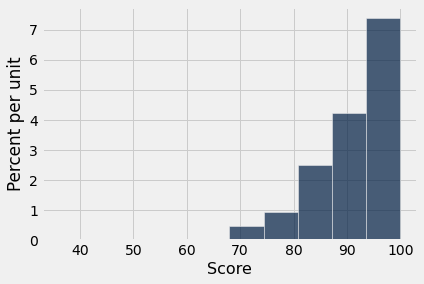

In [32]:
# Write your code here.
pop_restaurants.hist(3)

This is the population mean:

In [33]:
pop_mean = np.mean(pop_restaurants.column(3))
pop_mean

91.40706693478886

Often it is impossible to find complete datasets like this.  Imagine we instead had access only to a random sample of 100 restaurants, called `restaurant_sample`.  That table is created below. We are interested in using this sample to estimate the population mean.

In [34]:
restaurant_sample = pop_restaurants.sample(100, with_replacement=False)
restaurant_sample

Restaurant Name,Zip Code,Inspection Date,Score,Address
LW - Taco Bell,78734,12/14/2015,100,"1703 S FM 620 RD LAKEWAY, TX 78734 (30.345999, -97.964958)"
Texas Hillel Foundation,78705,10/29/2014,97,"2105 SAN ANTONIO ST AUSTIN, TX 78705 (30.28432, -97.742973)"
Sam's Club #8259,78748,01/15/2016,96,"9900 S IH 35 SVRD SB AUSTIN, TX 78748 (30.153976, -97.79 ..."
Lone Star Kolaches,78746,04/29/2014,83,"6317 FM 2244 RD AUSTIN, TX 78746 (30.296641, -97.832492)"
Club Tu Dia Es Hoy,78741,01/06/2016,100,"749 MONTOPOLIS DR AUSTIN, TX 78741 (30.236381, -97.696071)"
Shop 24,78701,11/24/2014,100,"213 E 6TH ST AUSTIN, TX 78701 (30.267528, -97.740931)"
Doc's Motorworks Bar & Grill,78704,02/24/2016,98,"1123 S CONGRESS AVE AUSTIN, TX 78704 (30.252478, -97.748589)"
Mi Pueblito Market,78741,12/17/2015,82,"2030 E OLTORF ST AUSTIN, TX 78741 (30.230232, -97.73207)"
"Verts Mediterranean Grill, Inc.",78741,01/28/2016,96,"1920 E RIVERSIDE DR Bunit 110 AUSTIN, TX 78741 (30.24193 ..."
Bryker Woods Elementary,78703,03/31/2015,100,"3309 KERBEY LN AUSTIN, TX 78703 (30.305408, -97.751429)"


#### Question 2
Plot the histogram of the **sample** scores. 

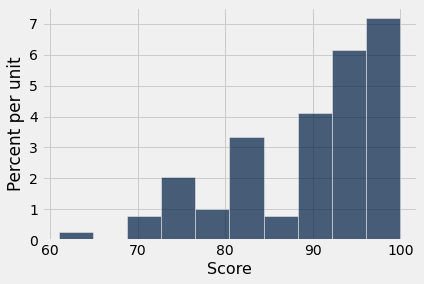

In [35]:
# Write your code here:
restaurant_sample.hist(3)

This is the **sample mean**:

In [36]:
sample_mean = np.mean(restaurant_sample.column(3))
sample_mean

89.93

#### Question 3
Complete the function `bootstrap_scores` below. It should take no arguments. It should simulate drawing 5000 resamples from `restaurant_sample` and computing the mean restaurant score in each resample.  It should return an array of those 5000 resample means.

In [37]:
def bootstrap_scores():
    resampled_means = make_array()
    for i in range(5000):
        resampled_mean = np.mean(pop_restaurants.sample(100, with_replacement=False).column(3))
        resampled_means = np.append(resampled_mean, resampled_means)
    return resampled_means

resampled_means = bootstrap_scores()
resampled_means

array([91.15, 92.45, 90.66, ..., 91.15, 92.15, 91.2 ])

#### Question 4
Make a histogram of the **resampled means**. What sort of a distribution do they look like they follow?

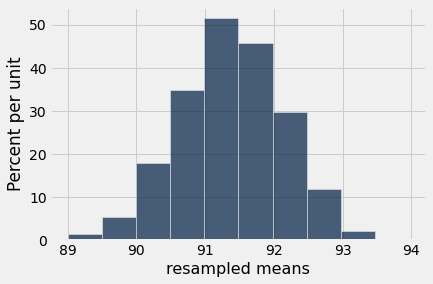

In [38]:
# Write your code here:
Table().with_column("resampled means", resampled_means).hist()

#### Question 5
Compute a 95 percent confidence interval for the average restaurant score.

In [39]:
lower_bound = percentile(2.5, resampled_means)
upper_bound = percentile(97.5, resampled_means)
print("95% confidence interval for the average restaurant score, computed by bootstrapping:\n(",lower_bound, ",", upper_bound, ")")

95% confidence interval for the average restaurant score, computed by bootstrapping:
( 89.87 , 92.78 )


#### Question 6
Throughout this section, we've looked at histograms of three distributions: the population, the sample, and the means of resamples taken from the sample. Do the population and sample distributions look similar to each other?  What about the population and the means of resamples? Which, if any, look normally distributed?

*The population and sample distributions look a slightly different. The resamples looks normally distributed.*

For the last question, you'll need to recall two facts.
1. If a group of numbers has a normal distribution, around 95% of them lie within 2 standard deviations of their mean.
2. The Central Limit Theorem tells us the quantitative relationship between
    * the standard deviation of an array of numbers and
    * the standard deviation of an array of means of samples taken from those numbers.

#### Question 7
Without referencing the array `resampled_means` or performing any new simulations, calculate an interval that covers approximately 95% of the numbers in that array.  **You may access `restaurant_sample`.**

In [41]:
pop_std = np.std(pop_restaurants.column(3))
# The staff solution included a few lines of code before this one.
lower_bound_normal = pop_mean - pop_std
upper_bound_normal = pop_mean + pop_std
print("95% confidence interval for the average restaurant score, computed by a normal approximation:\n(",lower_bound_normal, ",", upper_bound_normal, ")")

95% confidence interval for the average restaurant score, computed by a normal approximation:
( 83.73798328859405 , 99.07615058098366 )


This confidence interval should look very similar to the one you computed in question 5. If not, try calculating the inner 95 percent using 1.96 standard deviations instead of 2, for a more precise calculation. If they are still very different, there may be an error in your code.